# 知识蒸馏Pytorch

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.backends
from torch.utils.data import DataLoader
from torchinfo import summary

from tqdm import tqdm

In [12]:
# 设置随机数种子，便于复现
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
device
torch.backends.cudnn.benchmark = True

# 载入MNIST数据集

In [16]:
# ----------------------------------------------------------------------
# 载入训练集
# ----------------------------------------------------------------------
train_dataset = torchvision.datasets.MNIST(
    root = '/home/xianghao/data/',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download=False
)

test_dataset = torchvision.datasets.MNIST(
    root = '/home/xianghao/data/',
    train = False,
    transform = torchvision.transforms.ToTensor(),
    download=False
)

# 生成dataloader
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_dataset, 
    batch_size = 32, 
    shuffle = False
)

# 教师模型

In [26]:
class TeacherModel(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 10):
        super().__init__()
        self.fc1 = nn.Linear(784, 1200)
        self.fc2 = nn.Linear(1200, 2000)
        self.fc3 = nn.Linear(2000, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        
        return x

# 从头训练模型

In [27]:
model = TeacherModel()
model = model.to(device)
summary(model)

Layer (type:depth-idx)                   Param #
TeacherModel                             --
├─Linear: 1-1                            942,000
├─Linear: 1-2                            2,402,000
├─Linear: 1-3                            20,010
├─ReLU: 1-4                              --
├─Dropout: 1-5                           --
Total params: 3,364,010
Trainable params: 3,364,010
Non-trainable params: 0

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [30]:
epochs = 6
for epoch in range(epochs):
    model.train()
    for batch_idx, (inputs, targets) in tqdm(enumerate(train_dataloader)):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # 测试集评估
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            
            preds = model(x) # (batch, 10)
            predictions = preds.max(dim=1).indices
            num_correct += (predictions==y).sum()
            num_samples += predictions.size(0)
        acc = (num_correct/num_samples).item()
    print(f"Epoch:{epoch}\tAccuracy:{acc:.4f}")
        

1875it [00:06, 297.11it/s]


Epoch:0	Accuracy:0.9811


1875it [00:06, 301.86it/s]


Epoch:1	Accuracy:0.9818


1875it [00:06, 303.55it/s]


Epoch:2	Accuracy:0.9832


1875it [00:06, 304.09it/s]


Epoch:3	Accuracy:0.9804


1875it [00:06, 302.66it/s]


Epoch:4	Accuracy:0.9822


1875it [00:06, 303.06it/s]


Epoch:5	Accuracy:0.9835


In [31]:
teacher_model = model

In [32]:
class StudentModel(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 10):
        super().__init__()
        self.fc1 = nn.Linear(784, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
#         x = self.dropout(x)
        x = self.relu(x)
        
        x = self.fc2(x)
#         x = self.dropout(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        
        return x

# 从头训练学生模型

In [36]:
model = StudentModel()
model = model.to(device)

In [37]:
criteron = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [38]:
epochs = 6
for epoch in range(epochs):
    model.train()
    for batch_idx, (inputs, targets) in tqdm(enumerate(train_dataloader)):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # 测试集评估
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            
            preds = model(x) # (batch, 10)
            predictions = preds.max(dim=1).indices
            num_correct += (predictions==y).sum()
            num_samples += predictions.size(0)
        acc = (num_correct/num_samples).item()
    print(f"Epoch:{epoch}\tAccuracy:{acc:.4f}")

1875it [00:05, 318.45it/s]


Epoch:0	Accuracy:0.8546


1875it [00:05, 326.93it/s]


Epoch:1	Accuracy:0.8875


1875it [00:05, 322.31it/s]


Epoch:2	Accuracy:0.8991


1875it [00:05, 316.33it/s]


Epoch:3	Accuracy:0.9086


1875it [00:05, 321.59it/s]


Epoch:4	Accuracy:0.9144


1875it [00:05, 323.03it/s]


Epoch:5	Accuracy:0.9174


In [39]:
student_model_scratch = model

# 知识蒸馏训练学生模型

In [66]:
# 准备预训练好的教师模型
teacher_model.eval()

# 准备新的学生模型
model = StudentModel()
model = model.to(device)
model.train()

# 蒸馏温度
T = 9

# hard loss
hard_loss = nn.CrossEntropyLoss()
# hard loss权重
alpha = 0.3

# soft loss
soft_loss = nn.KLDivLoss(reduction='batchmean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [67]:
epochs = 6
for epoch in range(epochs):
    model.train()
    for batch_idx, (inputs, targets) in tqdm(enumerate(train_dataloader)):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # 教师模型预测
        with torch.no_grad():
            teacher_preds = teacher_model(inputs)
        # 学生模型预测
        student_preds = model(inputs)
        
        # 计算hard loss
        student_loss = hard_loss(student_preds, targets)
        
        #计算蒸馏loss
        distillation_loss = soft_loss(F.log_softmax(student_preds/T, dim=1), F.softmax(teacher_preds/T, dim=1))
        
        # 两个loss加权求和
        loss = alpha*student_loss + (1-alpha) * distillation_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # 测试集评估
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            
            preds = model(x) # (batch, 10)
            predictions = preds.max(dim=1).indices
            num_correct += (predictions==y).sum()
            num_samples += predictions.size(0)
        acc = (num_correct/num_samples).item()
    print(f"Epoch:{epoch}\tAccuracy:{acc:.4f}")

1875it [00:07, 248.70it/s]


Epoch:0	Accuracy:0.8530


1875it [00:07, 234.60it/s]


Epoch:1	Accuracy:0.8833


1875it [00:08, 217.10it/s]


Epoch:2	Accuracy:0.8914


1875it [00:08, 221.86it/s]


Epoch:3	Accuracy:0.8989


1875it [00:08, 221.04it/s]


Epoch:4	Accuracy:0.9019


1875it [00:08, 214.75it/s]


Epoch:5	Accuracy:0.9054


# 测试loss随T的变化

In [76]:
import matplotlib.pyplot as plt
def speculate():
    
    # 蒸馏温度
    T = [1,2,3,4,5,6,7,8,9,10]

    
    
    epochs = 6
    
    accs = []
    for t in T:
        # 准备预训练好的教师模型
        teacher_model.eval()

        # 准备新的学生模型
        model = StudentModel()
        model = model.to(device)
        model.train()
        

        # hard loss
        hard_loss = nn.CrossEntropyLoss()
        # hard loss权重
        alpha = 0.3

        # soft loss
        soft_loss = nn.KLDivLoss(reduction='batchmean')

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        for epoch in range(epochs):
            model.train()
            for batch_idx, (inputs, targets) in tqdm(enumerate(train_dataloader)):
                inputs = inputs.to(device)
                targets = targets.to(device)

                # 教师模型预测
                with torch.no_grad():
                    teacher_preds = teacher_model(inputs)
                # 学生模型预测
                student_preds = model(inputs)

                # 计算hard loss
                student_loss = hard_loss(student_preds, targets)

                #计算蒸馏loss
                distillation_loss = soft_loss(F.log_softmax(student_preds/t, dim=1), F.softmax(teacher_preds/t, dim=1))

                # 两个loss加权求和
                loss = alpha*student_loss + (1-alpha) * distillation_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # 测试集评估
            model.eval()
            num_correct = 0
            num_samples = 0
            with torch.no_grad():
                for x, y in test_dataloader:
                    x = x.to(device)
                    y = y.to(device)

                    preds = model(x) # (batch, 10)
                    predictions = preds.max(dim=1).indices
                    num_correct += (predictions==y).sum()
                    num_samples += predictions.size(0)
                acc = (num_correct/num_samples).item()
            print(f"Epoch:{epoch}\tAccuracy:{acc:.4f}")
        accs.append(acc)
    
    
    # 画图
    plt.plot(T, accs)

1875it [00:08, 218.63it/s]


Epoch:0	Accuracy:0.8451


1875it [00:09, 207.38it/s]


Epoch:1	Accuracy:0.8884


1875it [00:08, 211.94it/s]


Epoch:2	Accuracy:0.9028


1875it [00:08, 227.65it/s]


Epoch:3	Accuracy:0.9126


1875it [00:08, 212.99it/s]


Epoch:4	Accuracy:0.9172


1875it [00:08, 217.57it/s]


Epoch:5	Accuracy:0.9212


1875it [00:08, 214.15it/s]


Epoch:0	Accuracy:0.8398


1875it [00:08, 225.10it/s]


Epoch:1	Accuracy:0.8849


1875it [00:08, 228.66it/s]


Epoch:2	Accuracy:0.9003


1875it [00:08, 209.24it/s]


Epoch:3	Accuracy:0.9069


1875it [00:08, 212.02it/s]


Epoch:4	Accuracy:0.9136


1875it [00:08, 219.32it/s]


Epoch:5	Accuracy:0.9159


1875it [00:08, 215.41it/s]


Epoch:0	Accuracy:0.8202


1875it [00:08, 209.21it/s]


Epoch:1	Accuracy:0.8674


1875it [00:08, 219.41it/s]


Epoch:2	Accuracy:0.8838


1875it [00:08, 233.05it/s]


Epoch:3	Accuracy:0.8942


1875it [00:08, 222.22it/s]


Epoch:4	Accuracy:0.8992


1875it [00:08, 219.75it/s]


Epoch:5	Accuracy:0.9041


1875it [00:08, 228.62it/s]


Epoch:0	Accuracy:0.8274


1875it [00:08, 213.89it/s]


Epoch:1	Accuracy:0.8761


1875it [00:08, 210.95it/s]


Epoch:2	Accuracy:0.8936


1875it [00:08, 223.02it/s]


Epoch:3	Accuracy:0.9003


1875it [00:08, 221.36it/s]


Epoch:4	Accuracy:0.9053


1875it [00:08, 216.90it/s]


Epoch:5	Accuracy:0.9088


1875it [00:08, 214.97it/s]


Epoch:0	Accuracy:0.8520


1875it [00:08, 222.35it/s]


Epoch:1	Accuracy:0.8796


1875it [00:08, 211.44it/s]


Epoch:2	Accuracy:0.8900


1875it [00:08, 230.11it/s]


Epoch:3	Accuracy:0.8969


1875it [00:08, 212.43it/s]


Epoch:4	Accuracy:0.9010


1875it [00:08, 213.05it/s]


Epoch:5	Accuracy:0.9036


1875it [00:08, 211.92it/s]


Epoch:0	Accuracy:0.8205


1875it [00:08, 220.31it/s]


Epoch:1	Accuracy:0.8739


1875it [00:09, 204.47it/s]


Epoch:2	Accuracy:0.8936


1875it [00:08, 216.46it/s]


Epoch:3	Accuracy:0.9033


1875it [00:08, 209.04it/s]


Epoch:4	Accuracy:0.9074


1875it [00:08, 215.75it/s]


Epoch:5	Accuracy:0.9125


1875it [00:08, 212.62it/s]


Epoch:0	Accuracy:0.8462


1875it [00:09, 207.79it/s]


Epoch:1	Accuracy:0.8811


1875it [00:08, 221.61it/s]


Epoch:2	Accuracy:0.8932


1875it [00:08, 214.77it/s]


Epoch:3	Accuracy:0.8975


1875it [00:08, 219.58it/s]


Epoch:4	Accuracy:0.9042


1875it [00:08, 224.45it/s]


Epoch:5	Accuracy:0.9076


1875it [00:08, 231.91it/s]


Epoch:0	Accuracy:0.8604


1875it [00:07, 242.60it/s]


Epoch:1	Accuracy:0.8886


1875it [00:08, 224.99it/s]


Epoch:2	Accuracy:0.8987


1875it [00:08, 228.73it/s]


Epoch:3	Accuracy:0.9077


1875it [00:09, 204.64it/s]


Epoch:4	Accuracy:0.9131


1875it [00:10, 179.97it/s]


Epoch:5	Accuracy:0.9164


1875it [00:10, 182.31it/s]


Epoch:0	Accuracy:0.8456


1875it [00:10, 177.89it/s]


Epoch:1	Accuracy:0.8790


1875it [00:10, 178.76it/s]


Epoch:2	Accuracy:0.8949


1875it [00:10, 177.37it/s]


Epoch:3	Accuracy:0.9025


1875it [00:10, 178.46it/s]


Epoch:4	Accuracy:0.9075


1875it [00:10, 180.02it/s]


Epoch:5	Accuracy:0.9122


1875it [00:08, 222.50it/s]


Epoch:0	Accuracy:0.8557


1875it [00:08, 232.93it/s]


Epoch:1	Accuracy:0.8862


1875it [00:08, 228.79it/s]


Epoch:2	Accuracy:0.8945


1875it [00:08, 227.52it/s]


Epoch:3	Accuracy:0.9020


1875it [00:08, 225.88it/s]


Epoch:4	Accuracy:0.9087


1875it [00:08, 225.74it/s]


Epoch:5	Accuracy:0.9115


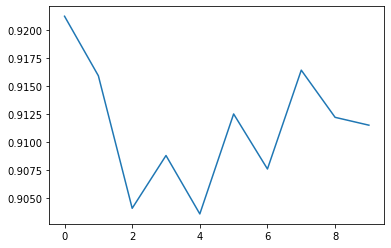

In [77]:
speculate()

In [78]:
def speculate2():
    
    # 蒸馏温度
    T = 7
    # hard loss权重
    alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

    
    
    epochs = 6
    
    accs = []
    for a in alpha:
        # 准备预训练好的教师模型
        teacher_model.eval()

        # 准备新的学生模型
        model = StudentModel()
        model = model.to(device)
        model.train()
        

        # hard loss
        hard_loss = nn.CrossEntropyLoss()
        

        # soft loss
        soft_loss = nn.KLDivLoss(reduction='batchmean')

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        for epoch in range(epochs):
            model.train()
            for batch_idx, (inputs, targets) in tqdm(enumerate(train_dataloader)):
                inputs = inputs.to(device)
                targets = targets.to(device)

                # 教师模型预测
                with torch.no_grad():
                    teacher_preds = teacher_model(inputs)
                # 学生模型预测
                student_preds = model(inputs)

                # 计算hard loss
                student_loss = hard_loss(student_preds, targets)

                #计算蒸馏loss
                distillation_loss = soft_loss(F.log_softmax(student_preds/T, dim=1), F.softmax(teacher_preds/T, dim=1))

                # 两个loss加权求和
                loss = a*student_loss + (1-a) * distillation_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # 测试集评估
            model.eval()
            num_correct = 0
            num_samples = 0
            with torch.no_grad():
                for x, y in test_dataloader:
                    x = x.to(device)
                    y = y.to(device)

                    preds = model(x) # (batch, 10)
                    predictions = preds.max(dim=1).indices
                    num_correct += (predictions==y).sum()
                    num_samples += predictions.size(0)
                acc = (num_correct/num_samples).item()
            print(f"Epoch:{epoch}\tAccuracy:{acc:.4f}")
        accs.append(acc)
    
    
    # 画图
    plt.plot(alpha, accs)

1875it [00:08, 233.94it/s]


Epoch:0	Accuracy:0.8008


1875it [00:08, 218.42it/s]


Epoch:1	Accuracy:0.8606


1875it [00:07, 236.56it/s]


Epoch:2	Accuracy:0.8759


1875it [00:07, 238.90it/s]


Epoch:3	Accuracy:0.8840


1875it [00:08, 212.14it/s]


Epoch:4	Accuracy:0.8886


1875it [00:08, 213.98it/s]


Epoch:5	Accuracy:0.8956


1875it [00:09, 206.25it/s]


Epoch:0	Accuracy:0.8367


1875it [00:08, 223.95it/s]


Epoch:1	Accuracy:0.8824


1875it [00:08, 213.22it/s]


Epoch:2	Accuracy:0.8943


1875it [00:08, 229.64it/s]


Epoch:3	Accuracy:0.9032


1875it [00:08, 222.16it/s]


Epoch:4	Accuracy:0.9076


1875it [00:08, 229.13it/s]


Epoch:5	Accuracy:0.9123


1875it [00:08, 212.78it/s]


Epoch:0	Accuracy:0.8230


1875it [00:07, 236.38it/s]


Epoch:1	Accuracy:0.8664


1875it [00:08, 220.56it/s]


Epoch:2	Accuracy:0.8850


1875it [00:08, 216.88it/s]


Epoch:3	Accuracy:0.8938


1875it [00:08, 222.63it/s]


Epoch:4	Accuracy:0.8994


1875it [00:08, 214.96it/s]


Epoch:5	Accuracy:0.9053


1875it [00:08, 223.39it/s]


Epoch:0	Accuracy:0.8268


1875it [00:08, 221.84it/s]


Epoch:1	Accuracy:0.8756


1875it [00:08, 231.75it/s]


Epoch:2	Accuracy:0.8927


1875it [00:08, 219.23it/s]


Epoch:3	Accuracy:0.9000


1875it [00:08, 223.66it/s]


Epoch:4	Accuracy:0.9064


1875it [00:08, 228.51it/s]


Epoch:5	Accuracy:0.9118


1875it [00:08, 224.72it/s]


Epoch:0	Accuracy:0.8536


1875it [00:07, 237.49it/s]


Epoch:1	Accuracy:0.8923


1875it [00:08, 217.49it/s]


Epoch:2	Accuracy:0.8994


1875it [00:08, 226.87it/s]


Epoch:3	Accuracy:0.9065


1875it [00:08, 217.11it/s]


Epoch:4	Accuracy:0.9106


1875it [00:08, 224.63it/s]


Epoch:5	Accuracy:0.9130


1875it [00:08, 218.27it/s]


Epoch:0	Accuracy:0.8514


1875it [00:08, 213.76it/s]


Epoch:1	Accuracy:0.8861


1875it [00:08, 233.17it/s]


Epoch:2	Accuracy:0.9007


1875it [00:08, 228.57it/s]


Epoch:3	Accuracy:0.9070


1875it [00:08, 224.04it/s]


Epoch:4	Accuracy:0.9117


1875it [00:08, 230.58it/s]


Epoch:5	Accuracy:0.9139


1875it [00:08, 228.64it/s]


Epoch:0	Accuracy:0.8429


1875it [00:07, 237.88it/s]


Epoch:1	Accuracy:0.8829


1875it [00:08, 221.37it/s]


Epoch:2	Accuracy:0.8983


1875it [00:08, 231.60it/s]


Epoch:3	Accuracy:0.9048


1875it [00:08, 232.30it/s]


Epoch:4	Accuracy:0.9114


1875it [00:07, 239.02it/s]


Epoch:5	Accuracy:0.9160


1875it [00:08, 221.69it/s]


Epoch:0	Accuracy:0.8637


1875it [00:08, 225.63it/s]


Epoch:1	Accuracy:0.8976


1875it [00:08, 221.32it/s]


Epoch:2	Accuracy:0.9091


1875it [00:08, 227.81it/s]


Epoch:3	Accuracy:0.9121


1875it [00:08, 233.33it/s]


Epoch:4	Accuracy:0.9159


1875it [00:07, 237.09it/s]


Epoch:5	Accuracy:0.9177


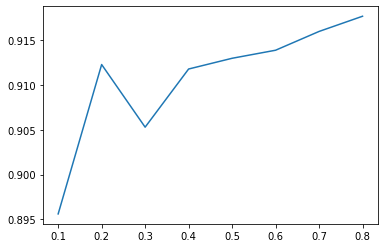

In [79]:
speculate2()